In [28]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from vortexasdk import CargoTimeSeries, Products, Geographies

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_columns = None

We continue our analysis for the period January 2023 - March 2025. January 2023 would mark the beginning of the end of the covid period with travel and economic demand starting to see a return to pre-covid levels. 
Whilst the memory of COVID is psychologically scarring for many individuals, it would be interesting to see whether the crude markets suffered the same effect.

In [29]:
#Defining date range for historical analysis
START_DATE = datetime(2023, 1, 2)
END_DATE = datetime(2025, 3, 15)
DATE_RANGE = pd.date_range(START_DATE, END_DATE)
#Floating storage unit (t = metric tonnes, b = barrels)
UNIT = 't'

In [30]:
def fetch_global_crude_floating_storage_timeseries(start_date, end_date, unit='t'):
    
    # Find Crude/Condensates ID, ensuring its uniqueness
    crude_and_condensates = [p.id for p in Products().search('crude').to_list() if p.name=='Crude/Condensates']
    assert len(crude_and_condensates) == 1
    
    # make Vortexa API query
    # NB: disable_geographic_exclusion_rules is set to True to include intra-movements
    df_fs = CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit=unit,
                                     intra_movements='all',
                                     filter_products=crude_and_condensates,
                                     filter_activity="storing_state",
                                     filter_time_min=start_date,
                                     filter_time_max=end_date).to_df()

    # rename columns
    df_fs = df_fs.rename(columns={'key': 'date',
                                  'value': unit,
                                  'count': 'number_of_cargo_movements'})
    
    # remove time zone from timestamp
    df_fs['date'] = pd.to_datetime(df_fs['date']).dt.tz_localize(None)
    
    return df_fs

- Fetching floating storage data from the Cargo Timeseries endpoint

In [31]:
df_fs = fetch_global_crude_floating_storage_timeseries(START_DATE, END_DATE, UNIT)
df_fs

,date,number_of_cargo_movements,t
0,2023-01-02,141,13022857
1,2023-01-03,150,13809475
2,2023-01-04,145,13396619
3,2023-01-05,151,14274049
4,2023-01-06,152,14766771
...,...,...,...
799,2025-03-11,92,8228153
800,2025-03-12,89,8133740
801,2025-03-13,96,8705582
802,2025-03-14,95,8263110


- The above dataframe contains the dates spanning January 2023 to March 2025 - approximately a 2.25 year period

Text(0, 0.5, 'Floating Storage (t)')

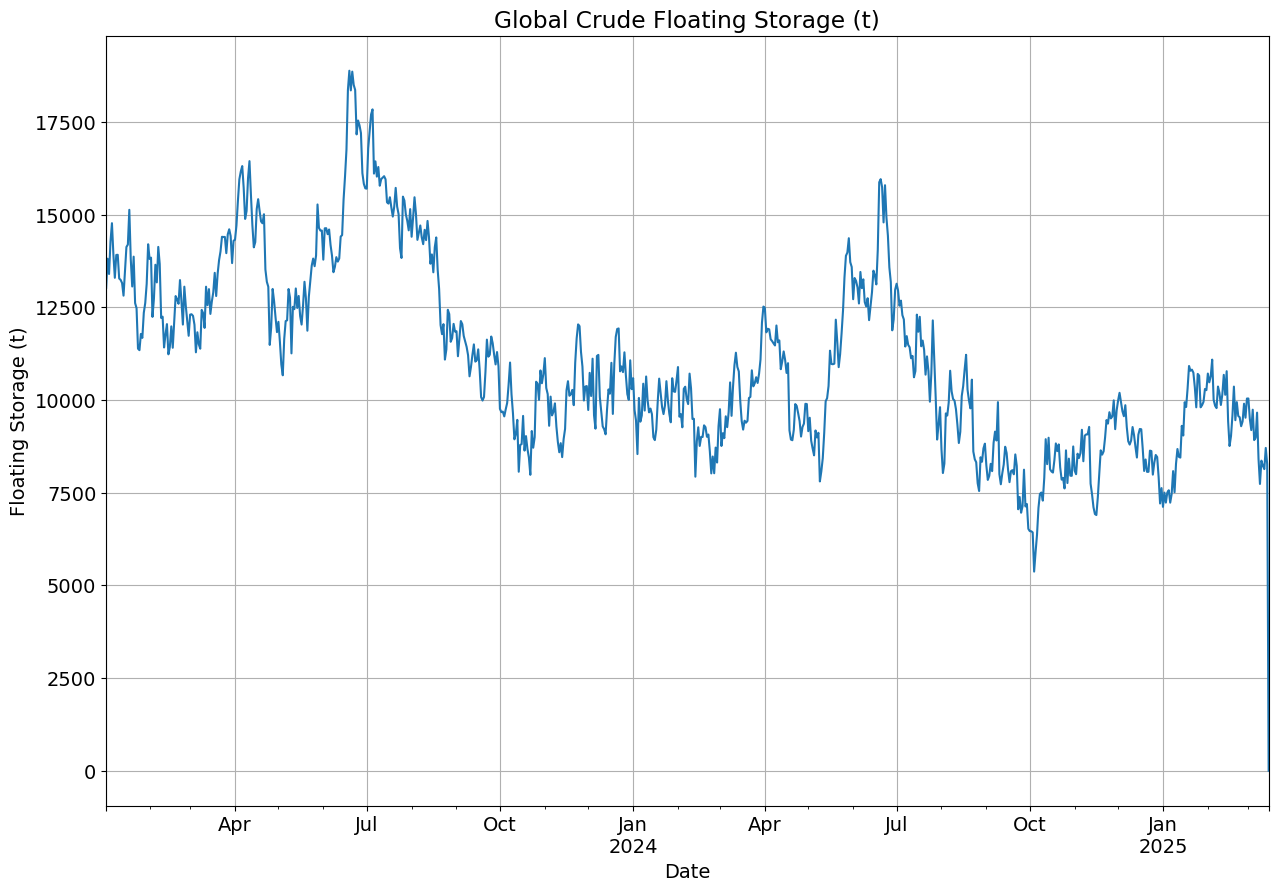

In [32]:
floating_storage = df_fs.set_index('date')[UNIT] / 1000
floating_storage.plot(title='Global Crude Floating Storage (t)', grid=True)
plt.xlabel('Date')
plt.ylabel('Floating Storage (t)')

The above is a pandas series holding the floating storage quantity over the period we are analysing. 
Much like previous years, floating storage levels experienced several spikes with periods of ranging stability. 
Following August 2023, there was a downwards shift where floating storage levels range more tightly between 7500 and 12500 with a notable spike in July 2024 which saw floating storage levels reach just over 15000.  

Below: EIA crude oil prices
The US Energy Information Administration (EIA) reports daily spot prices of crude oil and other products on their website. This data is publicly available and we download the Excel file directly into a Pandas DataFrame below. (NB: although the series has daily resolution, the Excel file is updated on a weekly basis. For details see the information in the Regular Weekly Releases box.) ffill is used to fill gaps in the price data, so we can compare the latest price against floating storage.

In [33]:
spot_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
spot_prices = spot_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
spot_prices

,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)",Europe Brent Spot Price FOB (Dollars per Barrel)
2023-01-02,80.16,82.82
2023-01-03,76.87,80.36
2023-01-04,72.82,75.31
2023-01-05,73.61,76.73
2023-01-06,73.77,76.41
...,...,...
2025-03-11,66.52,71.51
2025-03-12,67.65,72.36
2025-03-13,66.82,70.82
2025-03-14,67.43,71.94


We open the sheet containing the crude oil spot prices (sheet Data 1) in the DataFrame and see that it contains two series: Cushing, OK WTI Spot Price and Europe Brent Spot Price. WTI (West Texas Intermediate) is the name of a crude oil grade produced in the US, and Brent is a crude grade produced in the North Sea. Both prices are used as international benchmark in oil transactions. This data is plotted below.

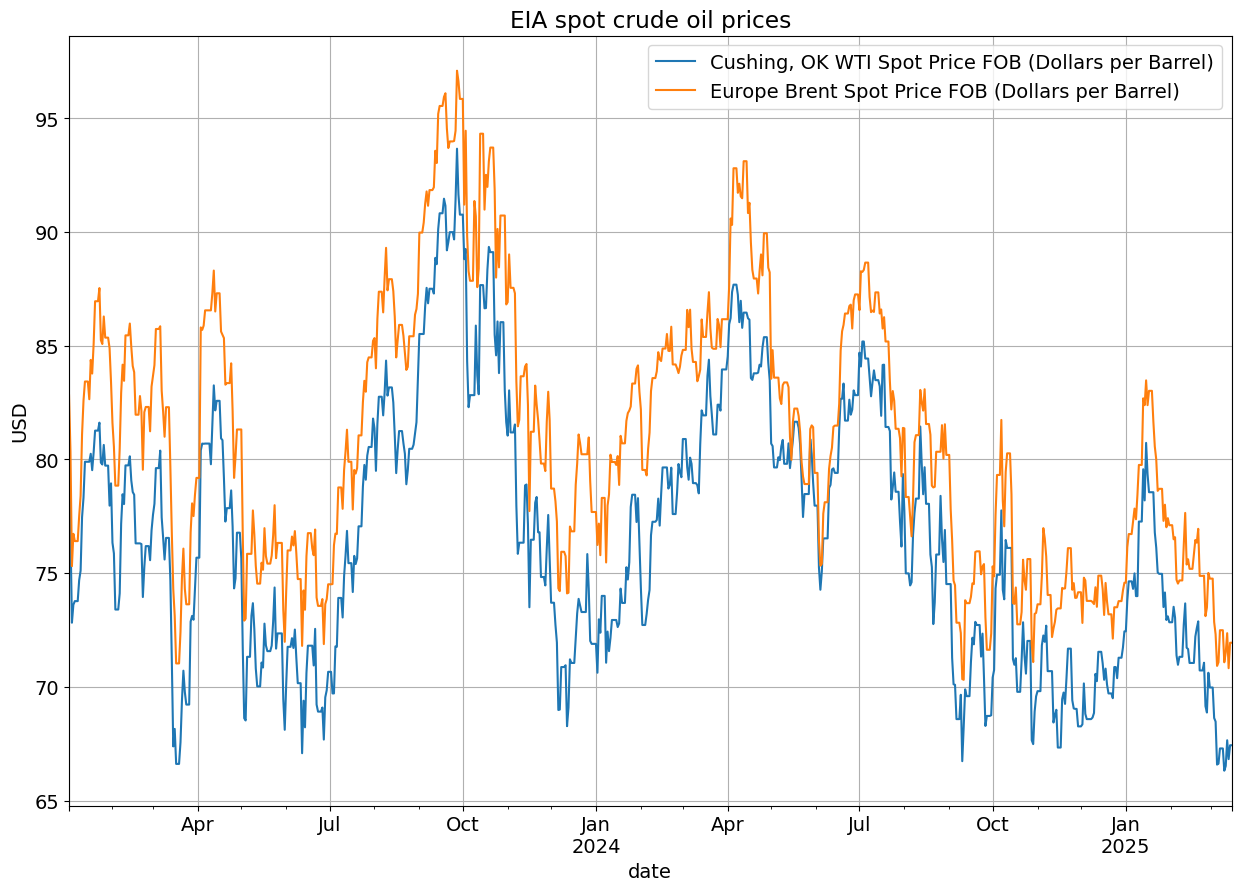

In [34]:
spot_prices.plot(title='EIA spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

Whilst not identical in levels, crude spot prices seem to have adopted a similar level of volatility and pattern to the pre-covid period in 2024.

We can see that crude prices increased significantly from the start of 2023 to October 2023,  where we saw a sharp rise from roughly $70/barrel to nearly $95/barrel. This rise was short-lived with prices decreasing back down to average levels of $75. 

The likely cause of this increase were the Russian and Saudi production cuts and rising demand from China. 


We proceed the analysis with Cushing, OK WTI Spot Price, which is kept as a Pandas Series below. We choose WTI because EIA provides both spot and future prices for WTI, but not for Brent.

- The line below extracts the first column of information from the spot prices data frame, excluding Brent prices. 

In [35]:
spot_prices = spot_prices.iloc[:, 0]

Next we retrieve future prices also from EIA. We download the Excel file with the historical price data of NYMEX WTI Future contracts into a DataFrame.

Note: Beyond the end of March 2024, EIA stop providing futures pricing. We use futures prices from Investing.com to conduct our analysis. The futures contracts on Investing.com have near identical prices to those of the EIA. 

In [36]:
file_path = "/Users/shafiquedassu/Documents/Projects/WTI_Crude_Futures_2023_2025.xls"
future_prices = pd.read_excel(file_path, header=0, usecols=[0, 1])
future_prices = future_prices.set_index('Date').reindex(DATE_RANGE, method='ffill')
future_prices

,Price
2023-01-02,80.47
2023-01-03,77.12
2023-01-04,73.10
2023-01-05,73.92
2023-01-06,74.04
...,...
2025-03-11,66.25
2025-03-12,67.68
2025-03-13,66.55
2025-03-14,67.18


The data above shows the prices of a crude oil futures contract with physical delivery of crude oil 2 months ahead. 

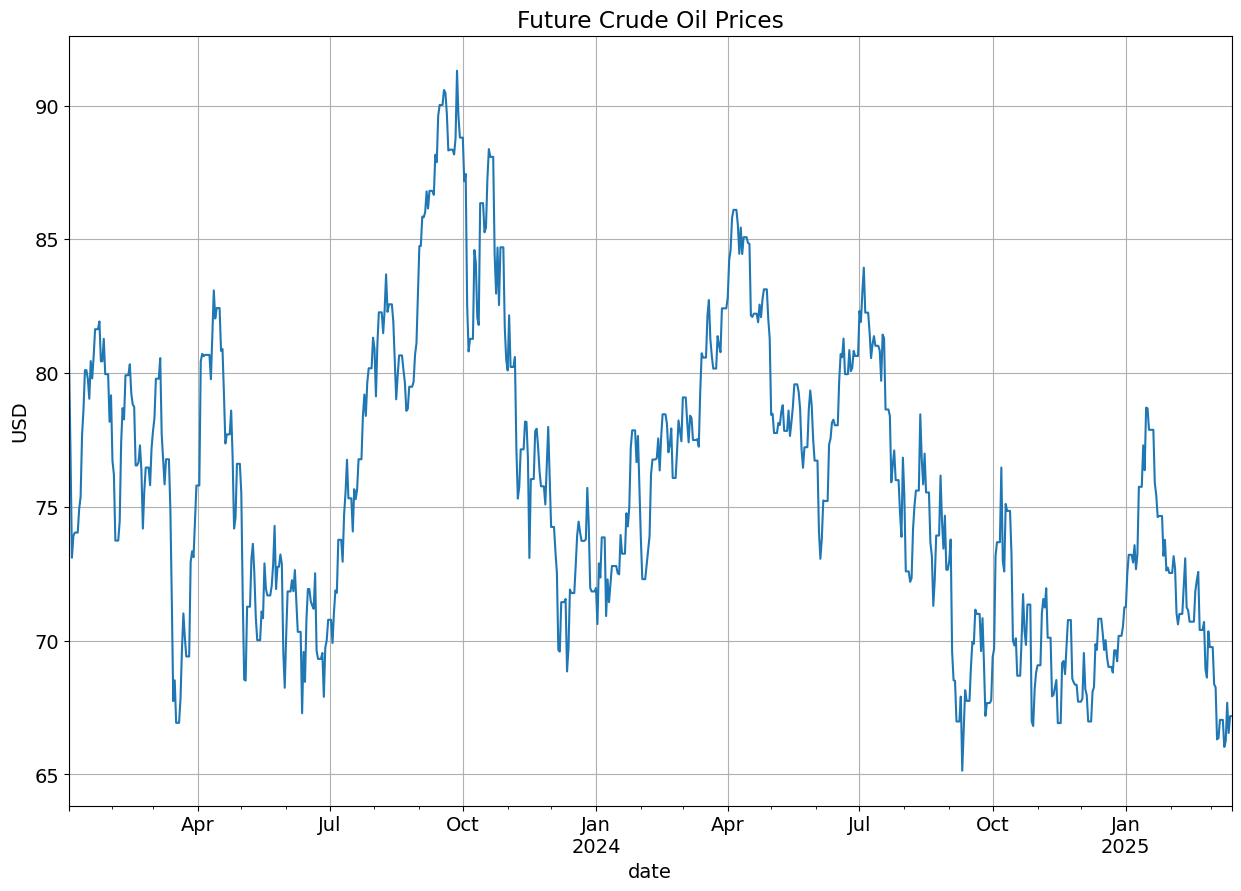

In [59]:
future_prices.plot(title='Future Crude Oil Prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

Next we calculate the difference between the future prices and the spot price, also known as calendar spread.

In [40]:
# calendar_spread
spot_prices = spot_prices.reindex(future_prices.index, method='ffill')
print(spot_prices.shape)
# calendar_spread = future_prices - spot_prices
# calendar_spread
calendar_spread = future_prices - pd.concat([spot_prices], axis=1).values
calendar_spread

(804,)


,Price
2023-01-02,0.31
2023-01-03,0.25
2023-01-04,0.28
2023-01-05,0.31
2023-01-06,0.27
...,...
2025-03-11,-0.27
2025-03-12,0.03
2025-03-13,-0.27
2025-03-14,-0.25


Below we plot the calendar spread which makes it easy to visualise when markets were in contango (spead > 0) and in backwardation (spread < 0)

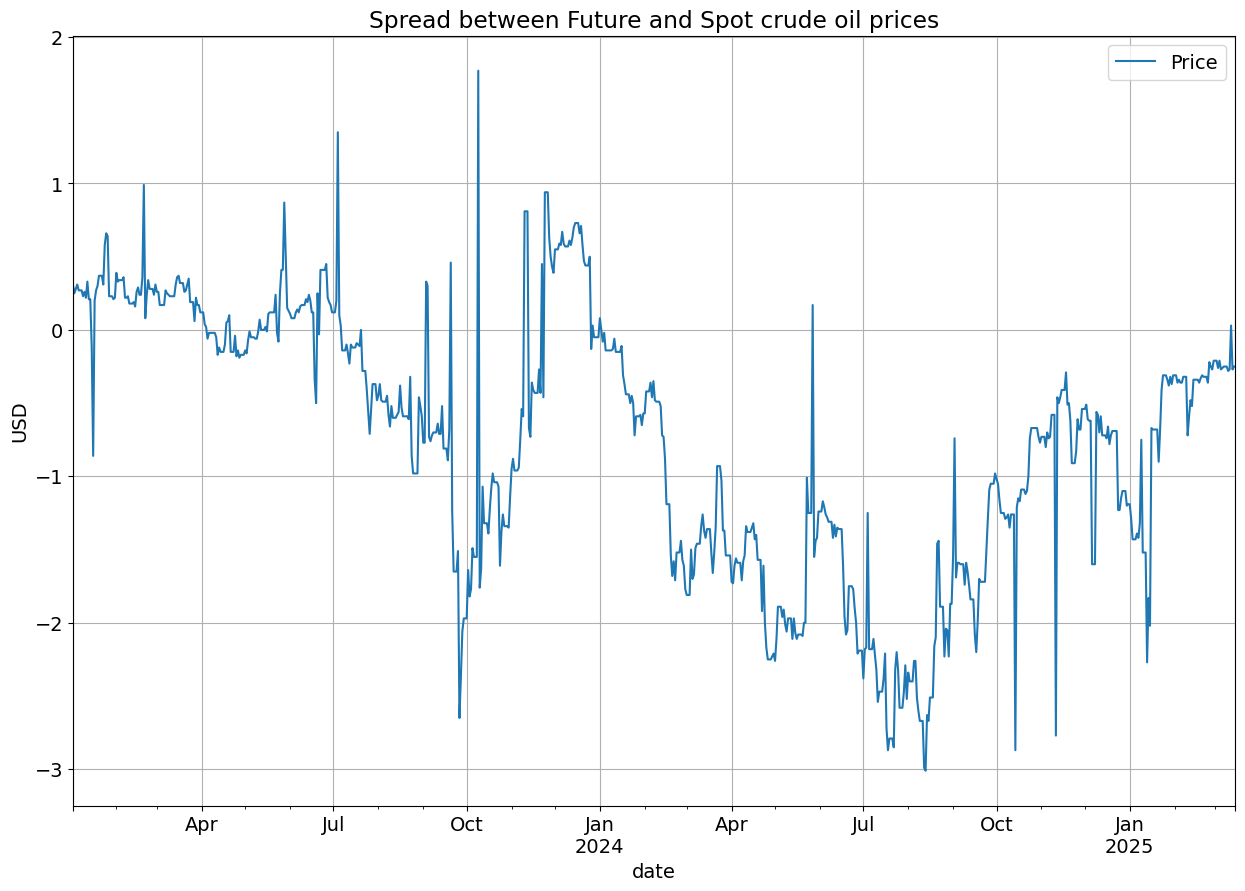

In [41]:
calendar_spread.plot(title='Spread between Future and Spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

In [42]:
future_prices = future_prices.iloc[:, 0]
calendar_spread = calendar_spread.iloc[:, 0]

## Cross Correlation Analysis

In [43]:
# Maximum lag in days used for cross-correlation and Granger causality analysis
MAXLAG = 100

In [44]:
def crosscorr(series_x, series_y, lags):
    return pd.Series([series_y.corr(series_x.shift(lag)) for lag in lags], index=lags)

In [45]:
crosscorr(calendar_spread, floating_storage, lags=[0, 1])

0    0.384007
1    0.390336
dtype: float64

We conduct a simple cross correlation analysis to investigate the relationship between floating storage and prices. We use pandas.Series.corr function to compute the Pearson correlation coefficient as we slide one of them in time using the shift function. 

All values are Pearson correlation coefficients between the two input variables. The index values correspond to the number of days the first variable is shifted "down" relative to the second one, so past values of the first variable are correlated against the present values of the second variable. In the above example, at index 1 "today's" floating storage is correlated with "yesterday's" calendar spread, or equivalently the calendar spread is correlated against floating storage 1 day in the future.

To help visualise the cross correlation between the different variables, we define the following function: 

In [56]:
def plot_crosscorr(series_x, series_y, maxlag, label_x, label_y):
    lags = np.arange(0, maxlag+1)

    plt.subplot(211)
    xcorr_x_y = crosscorr(series_x, series_y, lags)
    xcorr_x_y.plot(title=f'{label_x} -> {label_y}', grid=True)
    plt.ylabel('correlation coeff.')

    plt.subplot(212)
    xcorr_y_x = crosscorr(series_y, series_x, lags)
    xcorr_y_x.plot(title=f'{label_y} -> {label_x}', grid=True)
    plt.xlabel('lag [days]')
    plt.ylabel('correlation coeff.')

plot_crosscorr splits the cross-correlation results in two: the top plot has the correlation values between series_x and future values of series_y, and the bottom plot the correlation between series_y and future values of series_x. Plotting the cross-correlation between calendar spread and floating storage we obtain:

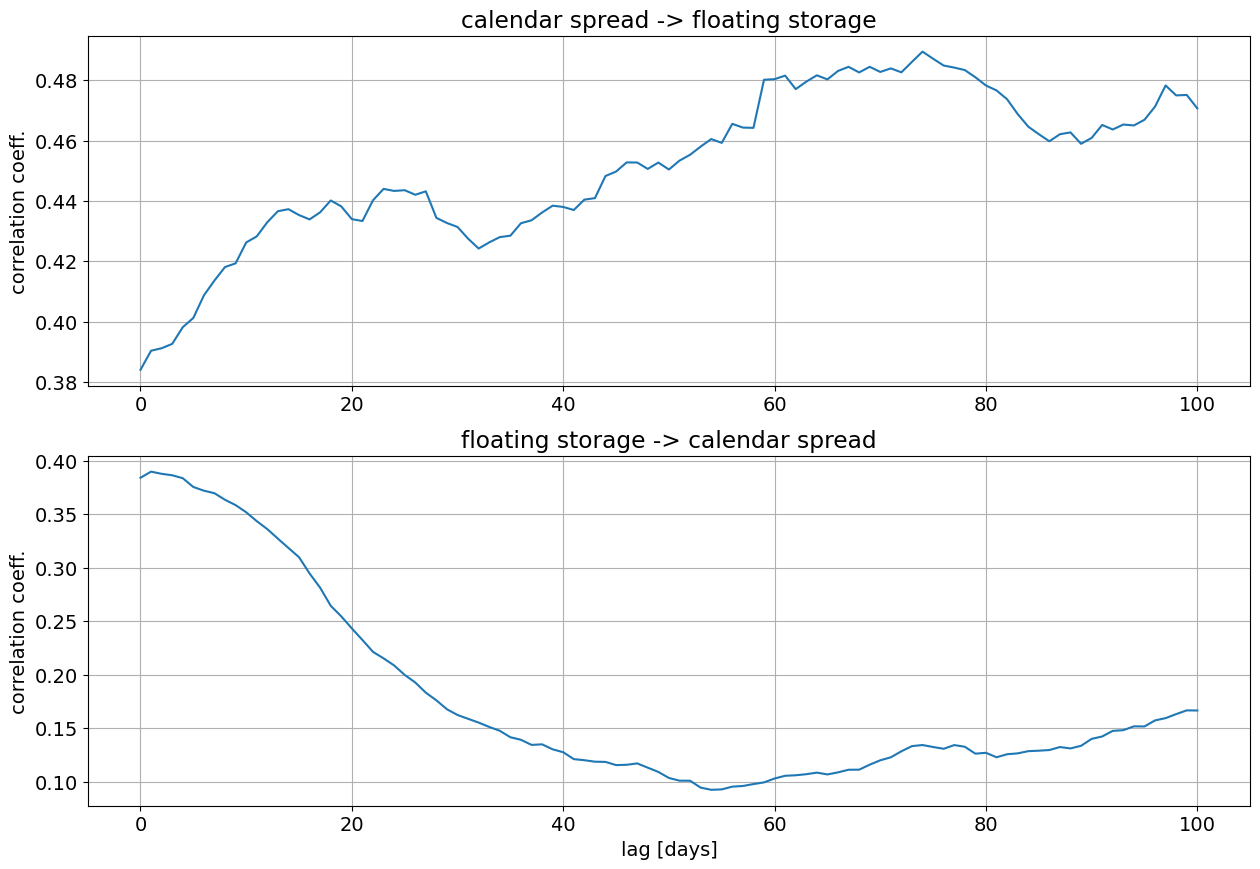

In [47]:
plot_crosscorr(calendar_spread, floating_storage, maxlag=MAXLAG, label_x='calendar spread', label_y='floating storage')

The top plot shows a generally positive correlaton for the effect of calendar spread on floating storage.

The bottom plot showing the correlation between floating storage and calendar spread starts and remains positive but gradually weakens to a minimum value of 0.10. This suggests that floating storage and calendar spreads move together. 

- Next we examine the cross correlation between spot prices and floating storage

(804,)
(804,)


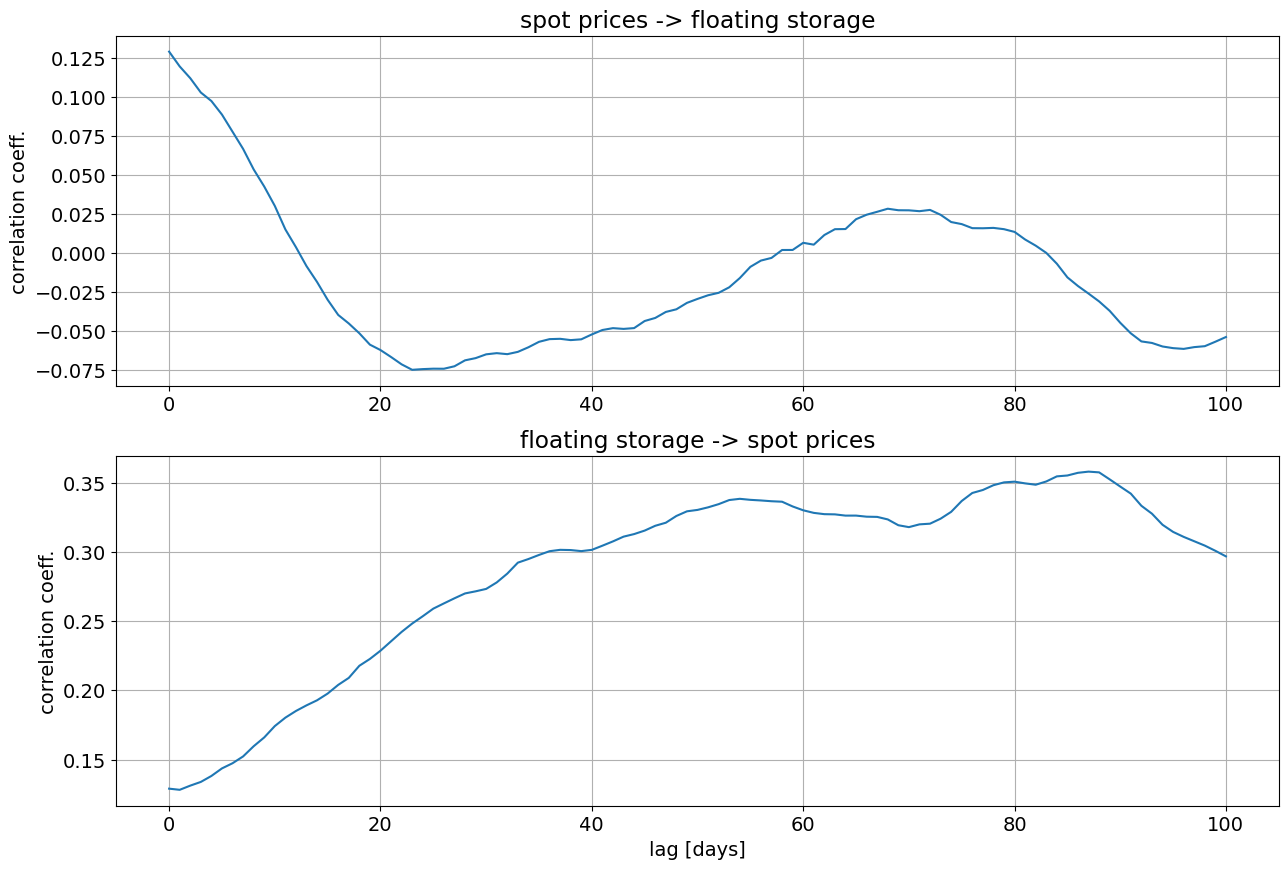

In [48]:
floating_storage = floating_storage.reindex(spot_prices.index, method='ffill')
spot_prices = spot_prices.squeeze()  # Converts to a 1D array
floating_storage = floating_storage.squeeze()  
print(spot_prices.shape)
print(floating_storage.shape)
plot_crosscorr(spot_prices, floating_storage, maxlag=MAXLAG, label_x='spot prices', label_y='floating storage')

In plot 1, the effect of spot prices on floating storage is surprising. The graph suggests that at lower lags, higher spot prices would lead to higher floating storage levels, however, this effect reverses after 10 days.

Plot 2 shows that floating storage positively leads spot prices across all lags. This is in stark contrast to pre-covid and covid levels where cross correlations in both plots were negative across all lags.

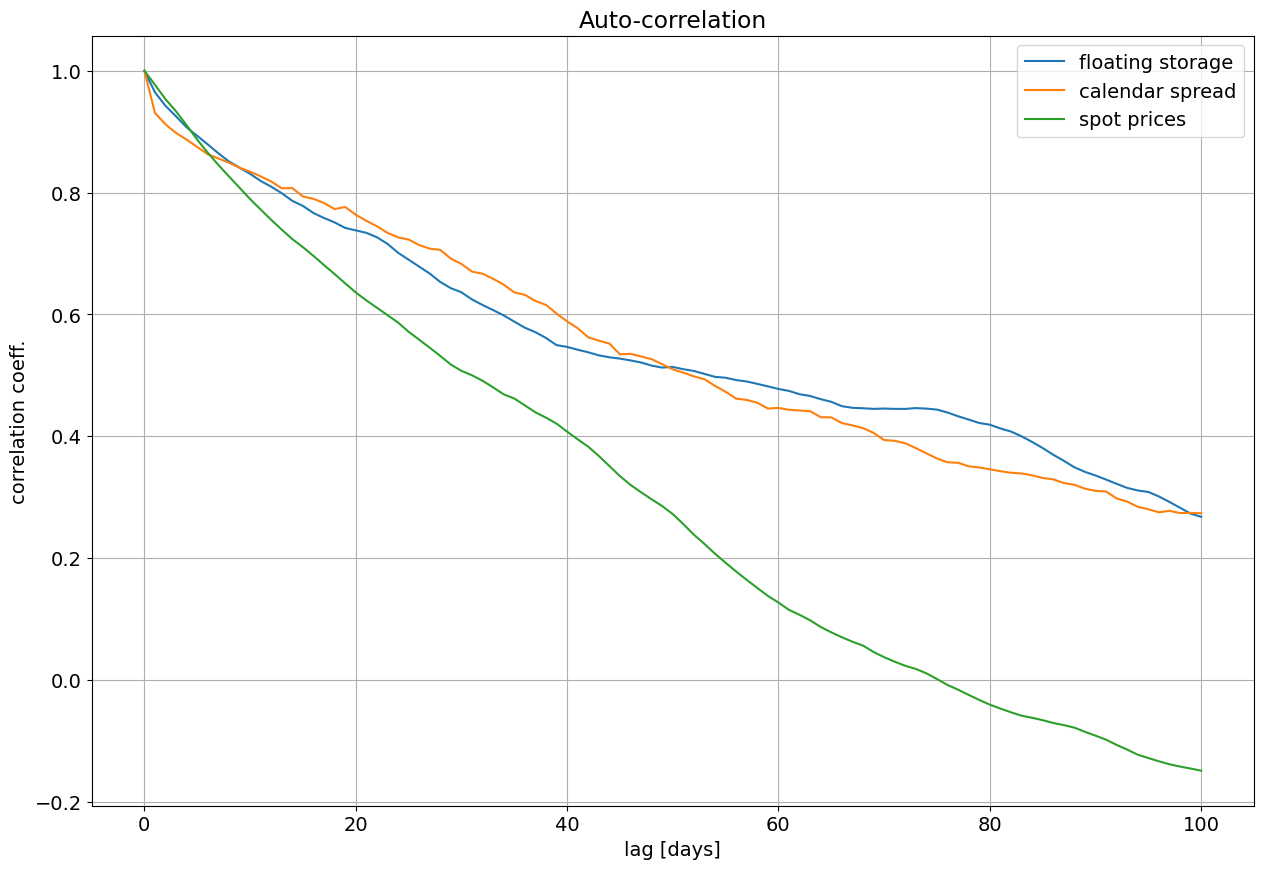

In [49]:
lags = np.arange(0, MAXLAG+1)

crosscorr(floating_storage, floating_storage, lags).plot()
crosscorr(calendar_spread, calendar_spread, lags).plot()
crosscorr(spot_prices, spot_prices, lags).plot()
plt.grid()
plt.title('Auto-correlation')
plt.legend(['floating storage', 'calendar spread', 'spot prices'])
plt.xlabel('lag [days]')
plt.ylabel('correlation coeff.');

The above graph shows the autocorrelation of spot prices, floating storage and calendar spread. 

- Floating storage and calendar spread (surprisingly) stay correlated with themselves the longest, even at higher lags the autocorrelation remains high. This suggests that these two variables are more persistent over time. This might suggest that post-covid, owners of floating storage were slower to adjust floating storage levels in response to prices.

- Spot prices deteriorate the fastest out of the three.

## Granger Causality Analysis

In [58]:
# gct = grangercausalitytests(pd.concat([floating_storage, calendar_spread], axis=1), maxlag=2, verbose=True)
# print(pd.concat([floating_storage, calendar_spread], axis=1).isna().sum())  # Count NaN values
# print(np.isinf(pd.concat([floating_storage, calendar_spread], axis=1)).sum()) 

spot_prices = spot_prices.replace([np.inf, -np.inf], np.nan).dropna()
floating_storage = floating_storage.replace([np.inf, -np.inf], np.nan).dropna()
calendar_spread = calendar_spread.replace([np.inf, -np.inf], np.nan).dropna()

# print("Floating Storage NaN count:", floating_storage.isna().sum())
# print("Calendar Spread NaN count:", calendar_spread.isna().sum())
# print("Spot Prices NaN count:", spot_prices.isna().sum())
# print("Infinite values in spot_prices:", np.isinf(spot_prices).sum())
# print("Infinite values in floating_storage:", np.isinf(floating_storage).sum())
# print("Infinite values in calendar_spread:", np.isinf(calendar_spread).sum())   


Above we clean the data of all NaN and inf values

In [52]:
# gct = grangercausalitytests(data, maxlag=2, verbose=True)
gct = grangercausalitytests(pd.concat([floating_storage, calendar_spread], axis=1), maxlag=2, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9898  , p=0.1588  , df_denom=800, df_num=1
ssr based chi2 test:   chi2=1.9972  , p=0.1576  , df=1
likelihood ratio test: chi2=1.9948  , p=0.1578  , df=1
parameter F test:         F=1.9898  , p=0.1588  , df_denom=800, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3856  , p=0.2508  , df_denom=797, df_num=2
ssr based chi2 test:   chi2=2.7885  , p=0.2480  , df=2
likelihood ratio test: chi2=2.7837  , p=0.2486  , df=2
parameter F test:         F=1.3856  , p=0.2508  , df_denom=797, df_num=2


We found no statistical significance in the p-values, implying floating storage has insignificant predictive power at both lags, 1 and 2

In [53]:
def plot_granger_pvalues(series_x, series_y, maxlag, label_x, label_y, test='ssr_ftest', confidence_level=0.05):
    lags = np.arange(1, maxlag+1)

    plt.subplot(211)
    gct_x_y = grangercausalitytests(pd.concat([series_y, series_x], axis=1), maxlag=maxlag, verbose=False)
    pvalue_x_y = pd.Series([gct_x_y[lag][0][test][1] for lag in lags], index=lags)
    pvalue_x_y.plot(title=f'{label_x} -> {label_y}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.ylabel('p-value')

    plt.subplot(212)
    gct_y_x = grangercausalitytests(pd.concat([series_x, series_y], axis=1), maxlag=maxlag, verbose=False)
    pvalue_y_x = pd.Series([gct_y_x[lag][0][test][1] for lag in lags], index=lags)
    pvalue_y_x.plot(title=f'{label_y} -> {label_x}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.xlabel('lag [days]')
    plt.ylabel('p-value')


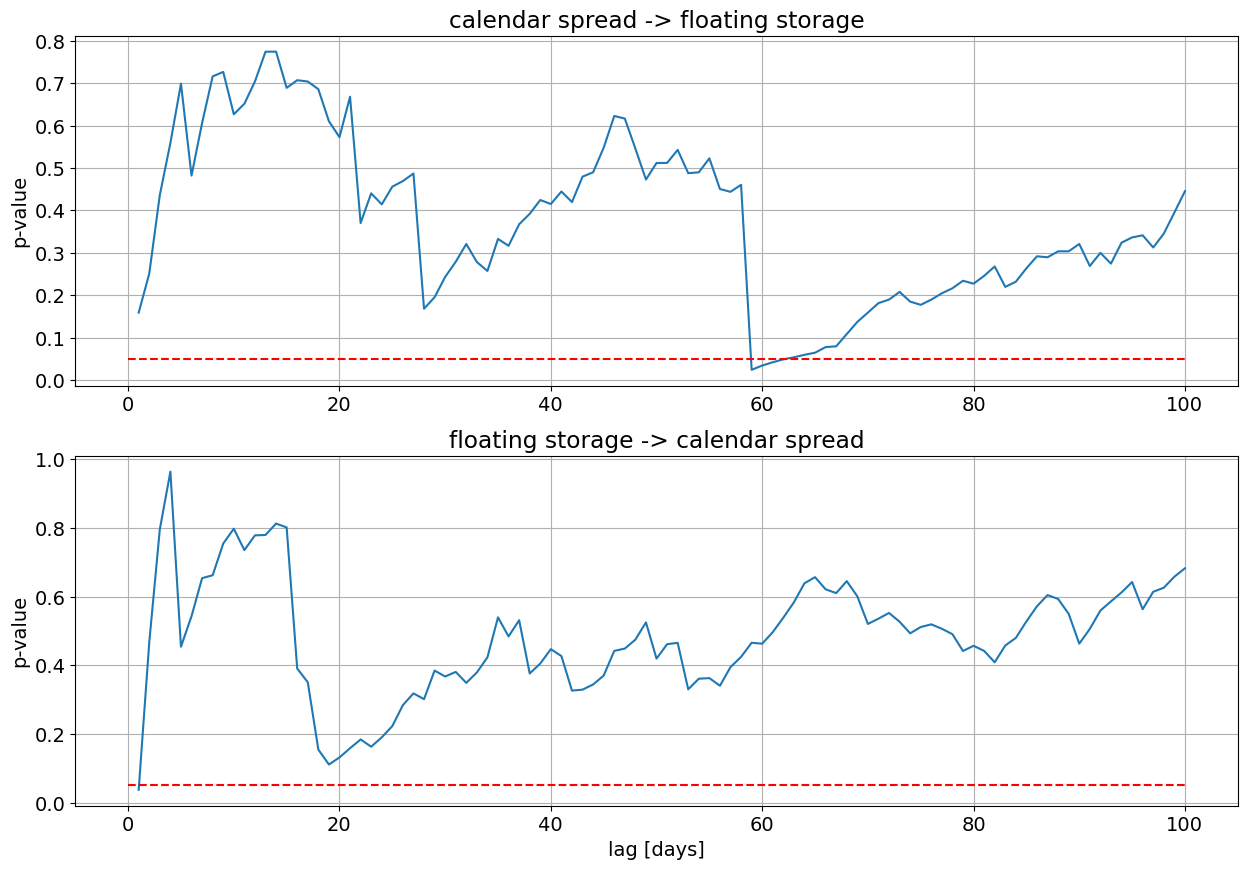

In [54]:
plot_granger_pvalues(calendar_spread, floating_storage, maxlag=MAXLAG, label_x='calendar spread', label_y='floating storage')

The blue lines indicate the p-values of the Granger causality tests. To identify the significant results we need to look where p-values dip below the threshold of significance, the dotted red lines. 

- Both plots show minimal periods of statistical significance. 

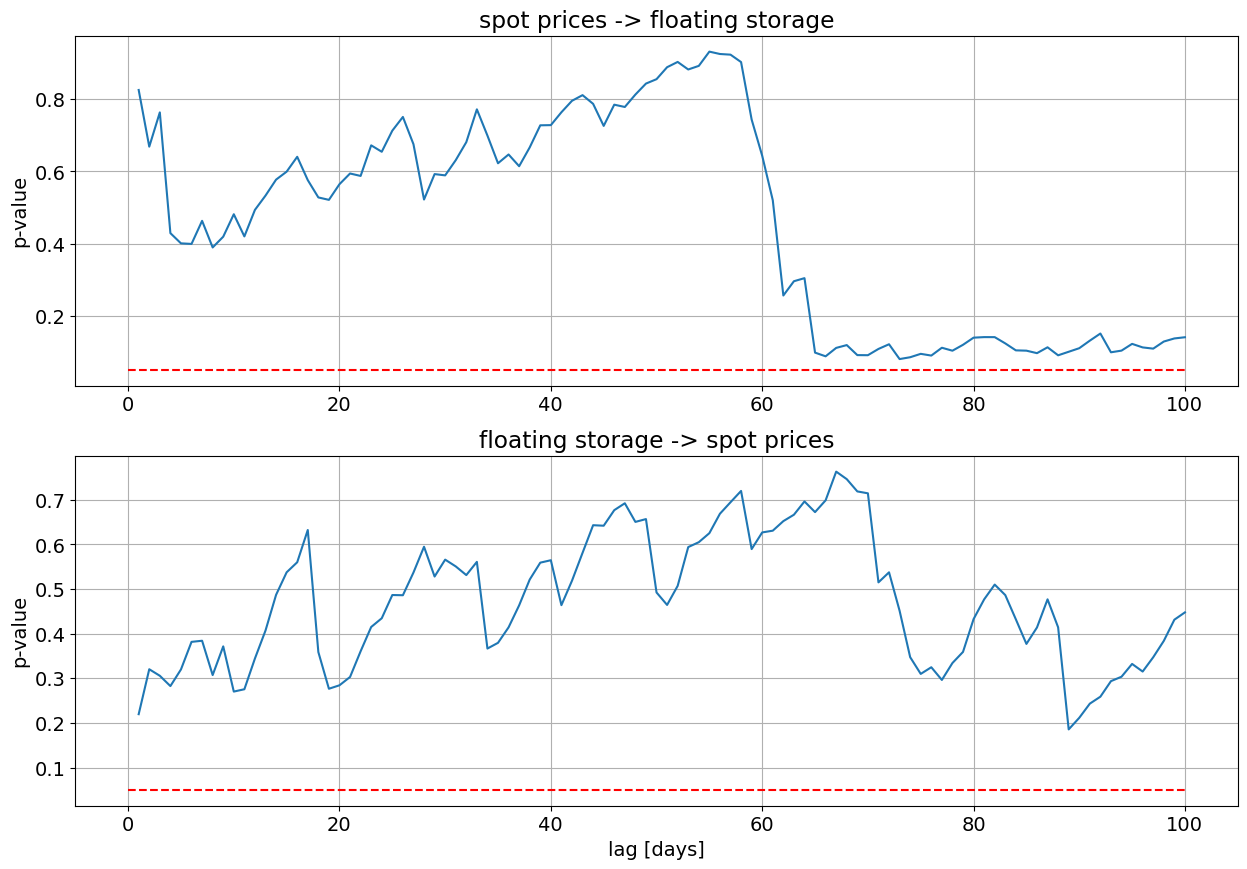

In [29]:
# Concatenate to ensure both series are aligned
data = pd.concat([spot_prices, floating_storage], axis=1)

# Remove NaNs and Inf values
data = data.replace([np.inf, -np.inf], np.nan).dropna()

# Split them back into separate series
spot_prices = data.iloc[:, 0]
floating_storage = data.iloc[:, 1]

plot_granger_pvalues(spot_prices, floating_storage, maxlag=MAXLAG, label_x='spot prices', label_y='floating storage')

These plots show that spot prices do not granger-cause floating storage levels and past floating storage levels have no predictive power over spot prices. 

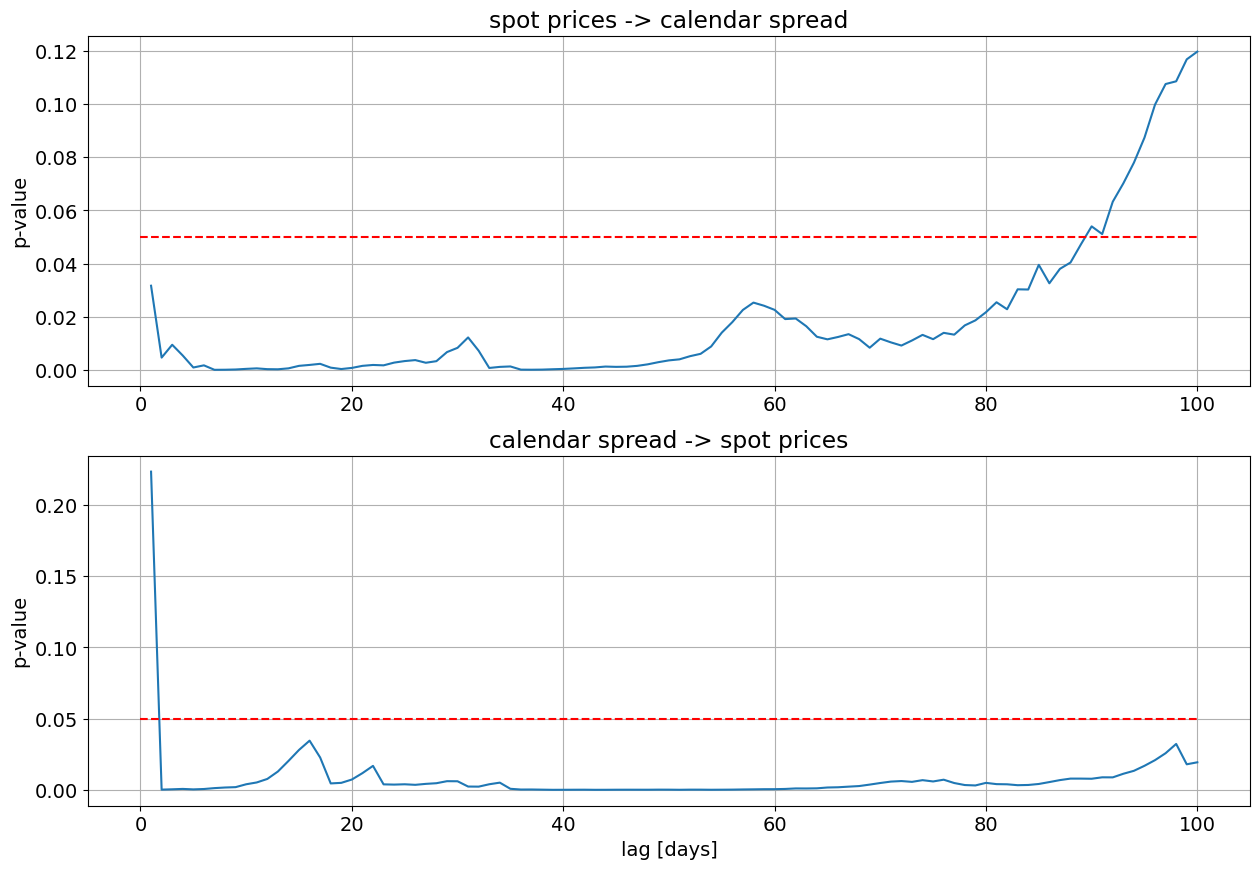

In [55]:
plot_granger_pvalues(spot_prices, calendar_spread, maxlag=MAXLAG, label_x='spot prices', label_y='calendar spread')

- Top Plot

Over very short lags (0–5 days), p-values are below 0.05, meaning that spot prices have significant predictive power over the calendar spread in the immediate short-term.
After lag ~20, p-values drop and remain at nearly 0.00, suggesting that spot prices have a persistent long-term predictive effect on calendar spreads.
We can say that spot prices significantly Granger-cause calendar spreads in the very short term and longer term (20 - 90 days). This suggests that futures prices are adjusted based on spot price movements. 
After 90 days the p-values rise above the statistically significant level of 0.05

- Bottom Plot 

Do past values of calendar spread help to predict spot prices? 
The p-values are extremely low for almost all lags above 2 indicating that calendar spreads Granger cause spot prices. 
This graph is nearly identical to covid and pre-covid levels indicating that the relationship of calendar spreads Granger-causing spot prices remains constant, surviving short term market cycles. 